In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset

import pandas as pd
import shutil

import matplotlib.pyplot as plt

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score

import os
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms

In [2]:
!curl -L -o Font_recognition.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip
!unzip -o  /content/Font_recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/9ac8a008-12f8-4eb9-a4ef-c2f2d78ccc4e.jpg  
  inflating: images/9adb4195-2a08-4a72-800b-0ceccdd92c56.jpg  
  inflating: images/9ae5ebcc-b744-458c-8ebc-c0bb00ded94a.jpg  
  inflating: images/9ae7c34f-e754-430a-af69-a269c82e0185.jpg  
  inflating: images/9aefd856-6027-4524-bf6b-585aaffc4f64.jpg  
  inflating: images/9af13c53-91e7-4dda-b880-f3d3fa0c3cc2.jpg  
  inflating: images/9afb1f5b-b579-4ea3-b6a8-11afe99c2ac0.jpg  
  inflating: images/9aff54d3-8d05-40e2-9961-0e497fdee70d.jpg  
  inflating: images/9b001318-5721-489f-956d-127dc01c4aba.jpg  
  inflating: images/9b116749-3595-40d6-b592-e78a8d534295.jpg  
  inflating: images/9b12ef52-33f7-431d-83a2-2b7ee3d55e76.jpg  
  inflating: images/9b157027-bb83-40c1-b61b-8bcce87a8c9b.jpg  
  inflating: images/9b1b93f3-4486-4f81-bc9c-22dc7e618e6f.jpg  
  inflating: images/9b1e81ed-04f0-4180-8ef3-051c94f64739.jpg  
  inflating: images/9b1f0e9e-db1c-48dd-835f-c61b1951a4b2.jpg  
  in

In [3]:
def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
    df = pd.read_csv(csv_path)

    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    for index, row in df.iterrows():
        image_path = row['image_path']
        if has_labels:
            font = row.get('font', 'unknown_font')
            font_size = row.get('font_size', 'unknown_size')
            color = row.get('color', 'unknown_color').replace("#", "")

            class_folder = os.path.join(
                output_base_folder,
                color,
                font,
                f"size_{font_size}"
            )
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        else:
            class_folder = output_base_folder

        source = os.path.join(images_folder, os.path.basename(image_path))
        destination = os.path.join(class_folder, os.path.basename(image_path))

        if os.path.exists(source):
            shutil.copy2(source, destination)
        else:
            print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

train_csv_path = '/content/train.csv'
test_csv_path = '/content/test.csv'
images_folder = '/content/images'

train_output_base_folder = '/content/train_pic'
test_output_base_folder = '/content/test_pic'

process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

In [4]:
class MultiAlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.color_mapping = {'FF6666': 0, '0000FF': 1, 'A020F0': 2, 'DF3030': 3, '26E953': 4}
        self.font_mapping = {'Athiti-Regular': 0, 'Sarabun-Regular': 1, 'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 'Prompt-Regular': 4, 'KhaosuayThin': 5, 'FkBeautyRegular': 6}
        self.font_size_mapping = {18: 0, 20: 1, 22: 2, 24: 3, 26: 4, 28: 5}

        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():
                color = color_dir.name
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():
                        font = font_dir.name
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):
                                font_size = int(size_dir.name.split('_')[1])
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():
                                        self.samples.append((file.path, font, font_size, color))

        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, font, font_size, color = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Encode labels as tensors
        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        return image, color_encoded, font_encoded, font_size_encoded

In [5]:
class ReverseIntensity:
  def __init__(self, threshold=150):
    self.threshold = threshold

  def __call__(self, image):

    if isinstance(image, Image.Image):
      image_np = np.array(image)
    elif isinstance(image, np.ndarray):
      image_np = image
    else:
      raise TypeError("Unsupported type. Expected PIL Image or numpy array.")

    if np.mean(image_np) > self.threshold:
      reversed_image = 255 - image_np
      return Image. fromarray(reversed_image)
    else:
      return image

In [6]:
class MedianBlur(object):
    def __init__(self, kernel_size=1):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = img.filter(ImageFilter.MedianFilter(size=self.kernel_size))
        return img

transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(contrast=0.1),
    transforms.ToTensor(),
])
root_dir = train_output_base_folder
dataset = MultiAlphabetDataset(root_dir=root_dir, transform=transform)

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, colors, fonts, font_sizes = next(iter(dataloader))

color_names = [reverse_color_mapping[int(color)] for color in colors]
font_names = [reverse_font_mapping[int(font)] for font in fonts]
font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

print(f"Batch Images Shape: {images.shape}")
print(f"Batch Colors: {color_names}")
print(f"Batch Fonts: {font_names}")
print(f"Batch Font Sizes: {font_size_names}")

Total samples found: 10080
Batch Images Shape: torch.Size([4, 3, 224, 224])
Batch Colors: ['DF3030', 'DF3030', '26E953', 'A020F0']
Batch Fonts: ['FkBeautyRegular', 'NotoSerifThai-Regular', 'Athiti-Regular', 'FkBeautyRegular']
Batch Font Sizes: [20, 18, 24, 24]


In [7]:
class RemoveWhiteNoiseAndBackground:
    def __init__(self, threshold=(200, 200, 200)):
            self.threshold = threshold

    def __call__(self, img):
            img_np = np.array(img)

            #สร้าง mask สำหรับ noise pixel
            mask = (img_np[..., 0] >= self.threshold[0]) & \
                (img_np[..., 1] >= self.threshold[1]) & \
                (img_np[..., 2] >= self.threshold[2])

            img_np[mask] = [255, 255, 255]

            # เปลี่ยนกลับเป็น PIL Image
            return Image.fromarray(img_np)
import cv2
class BilateralFilter:
    def __init__(self, d=9, sigmaColor=75, sigmaSpace=75):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def __call__(self, img):
        #เปลี่ยน PIL Image เป็น numpy array
        img_np = np.array(img)

        filtered_img_np = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)

        # เปลี่ยนกลับ
        filtered_img = Image.fromarray(filtered_img_np)

        return filtered_img


In [8]:
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dir = train_output_base_folder

    train_transform =transforms.Compose([
                    BilateralFilter(d=5, sigmaColor=60, sigmaSpace=60),
                    RemoveWhiteNoiseAndBackground(),
                    transforms.RandomAffine(degrees=(0),
                                            translate=(0.05, 0.05),
                                            scale=(1.0, 1.0),
                                            shear=0),
                    transforms.CenterCrop((64, 512)),
                    transforms.ToTensor(),
    ])

    dataset = MultiAlphabetDataset(root_dir=root_dir, transform=train_transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [9]:
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

Total samples found: 10080


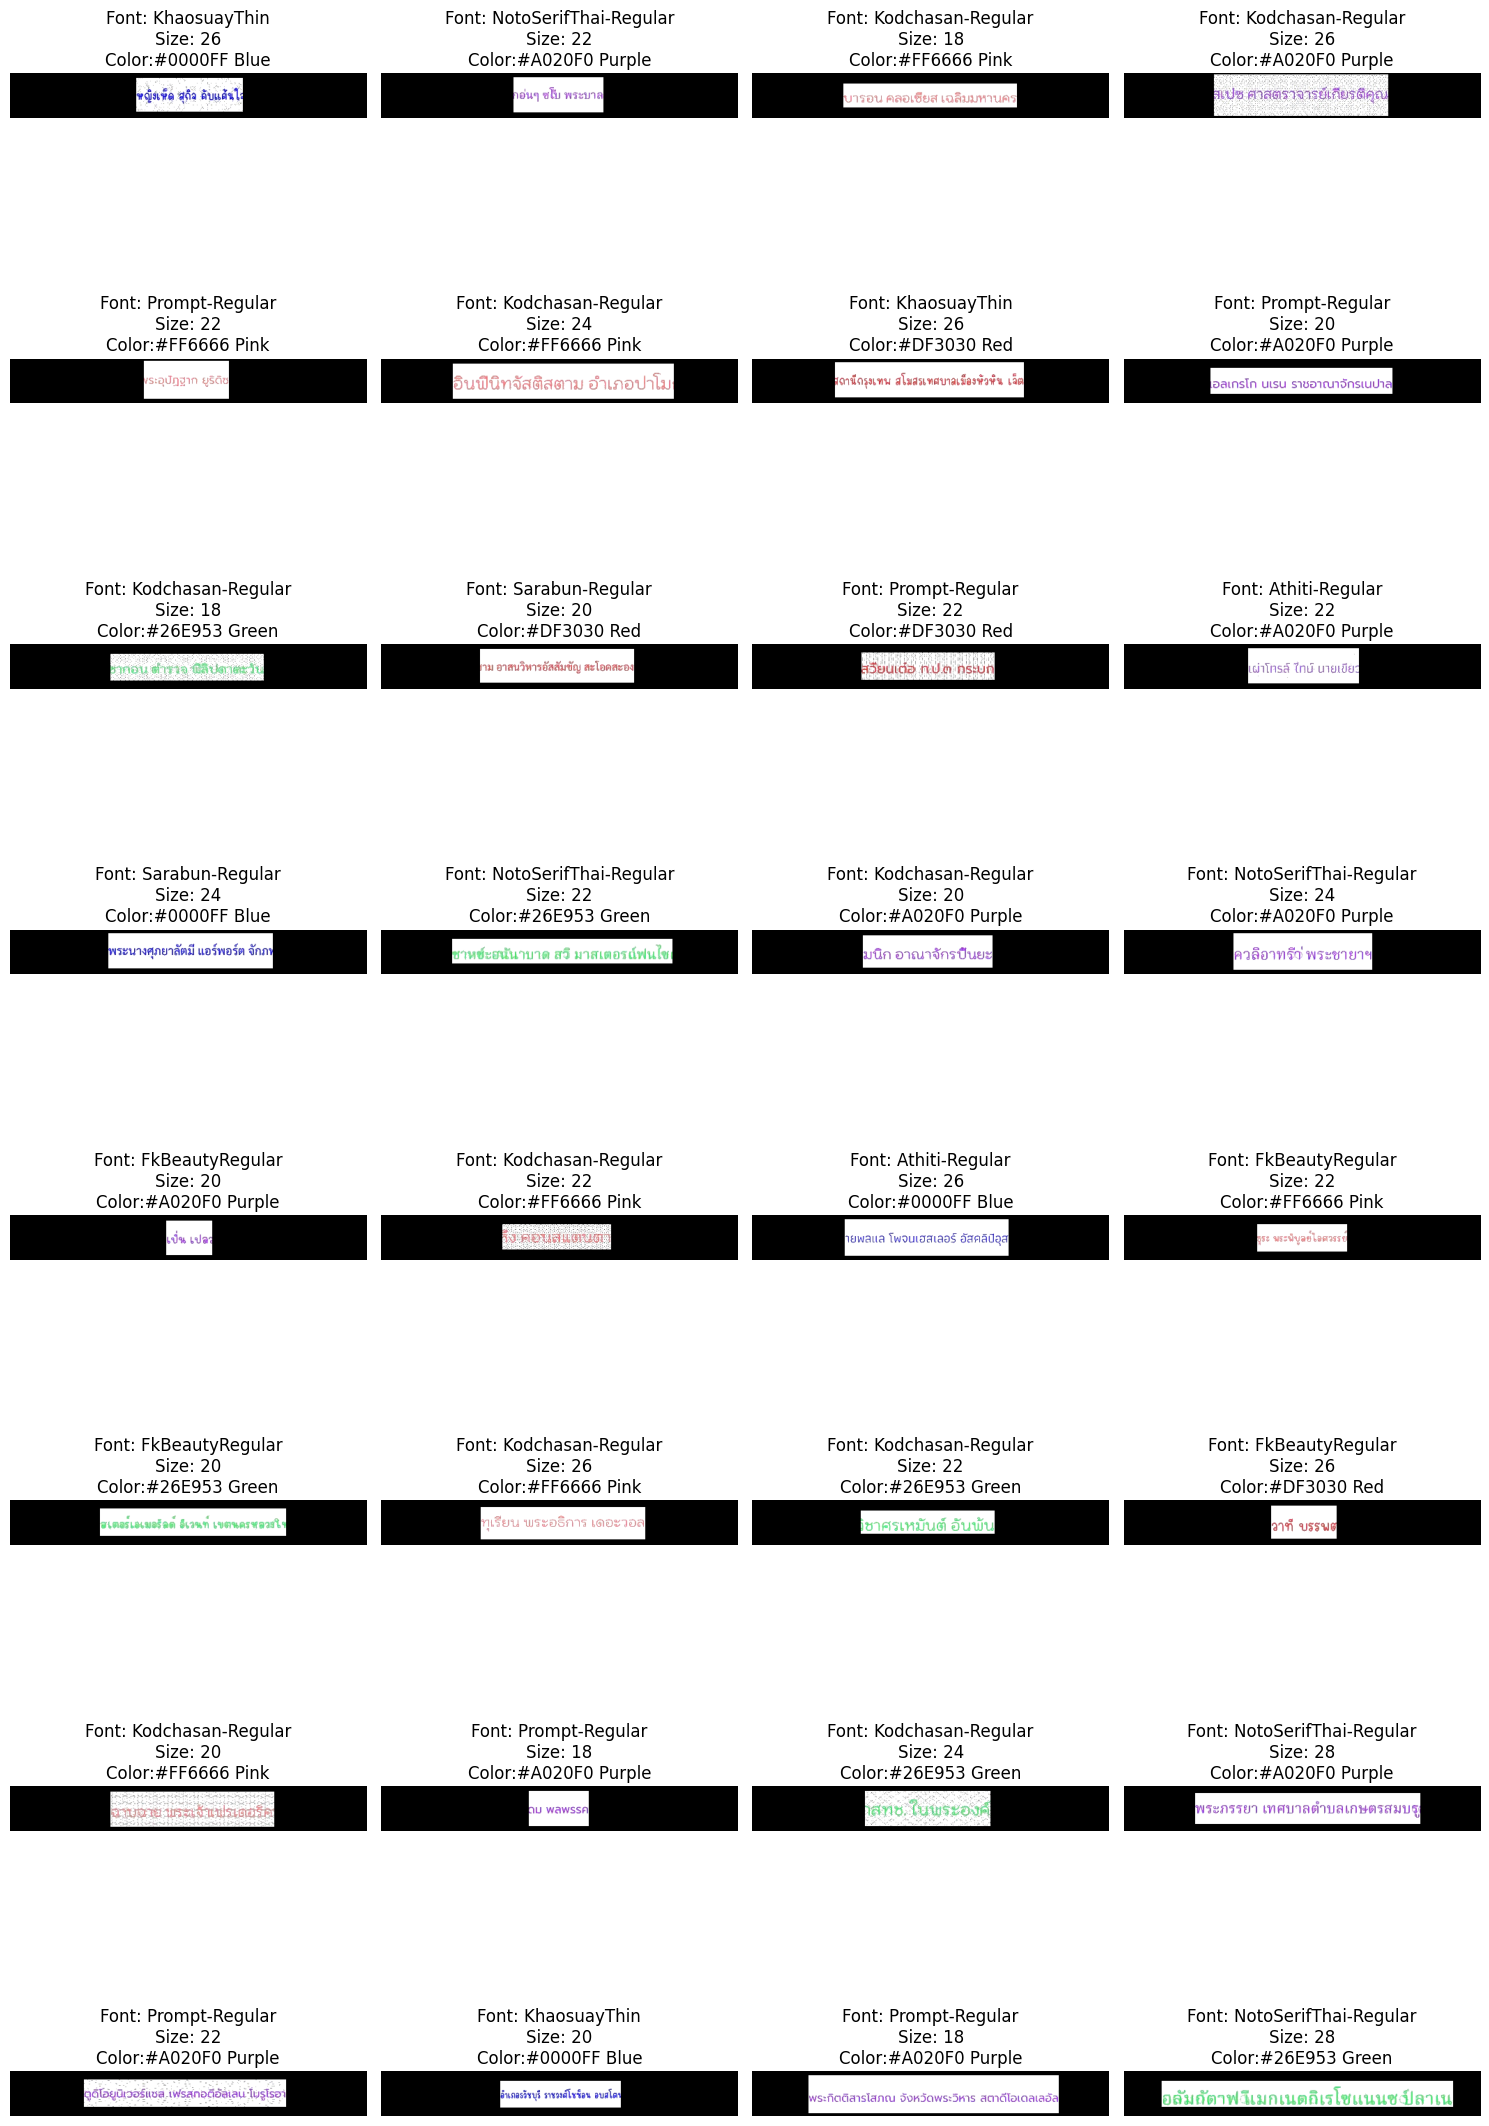

In [10]:
#Plot Example of train dataset
color_name_map = {
    'FF6666': 'Pink',
    '0000FF': 'Blue',
    'A020F0': 'Purple',
    'DF3030': 'Red',
    '26E953': 'Green'
}
batch_size = 32
images, colors, fonts, font_sizes = next(iter(train_loader))

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = reverse_color_mapping[int(color)]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor:#{color_name} {color_name_map[color_name]}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet(nn.Module):
    def __init__(self,
                 num_colors=5,
                 num_fonts=7,
                 num_sizes=6,
                 h_dims_color=[],
                 h_dims_font=[],
                 h_dims_size=[],
                 input_size=(3, 64, 512)):
        super(CustomResNet, self).__init__()

        self.resnet = models.resnet50(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.25))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)

        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        return color_output, font_output, size_output

In [12]:
num_colors = 5
num_fonts = 7
num_sizes = 6
best_score = 0.0
def calculate_fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2
    return (1 + beta_squared) * (precision * recall) / ((beta_squared * precision) + recall + 1e-7)

def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          beta=1,
          checkpoint_path=None,
          device='cpu'):
    global best_score
    model = model.to(device)
    print("🤖 Training on", device)

    for epoch in range(epochs):
        model.train()
        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader,
                         desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()

            color_output, font_output, size_output = model(data)
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            loss = loss_color*0.5 + loss_font*1 + loss_size*1.5

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()


        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                color_output, font_output, size_output = model(data)

                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                color_pred = color_output.argmax(dim=1, keepdim=True)
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            accuracy_color = 100. * correct_color / len(test_loader.dataset)
            accuracy_font = 100. * correct_font / len(test_loader.dataset)
            accuracy_size = 100. * correct_size / len(test_loader.dataset)

            precision_color = precision_score(all_color_targets, all_color_preds, average='weighted')
            recall_color = recall_score(all_color_targets, all_color_preds, average='weighted')
            precision_font = precision_score(all_font_targets, all_font_preds, average='weighted')
            recall_font = recall_score(all_font_targets, all_font_preds, average='weighted')
            precision_size = precision_score(all_size_targets, all_size_preds, average='weighted')
            recall_size = recall_score(all_size_targets, all_size_preds, average='weighted')

            fbeta_color = calculate_fbeta_score(precision_color, recall_color, beta)
            fbeta_font = calculate_fbeta_score(precision_font, recall_font, beta)
            fbeta_size = calculate_fbeta_score(precision_size, recall_size, beta)

            fbeta_total = (fbeta_font)*0.3 + (fbeta_color)*0.2 + (fbeta_size)*0.5

            print(f'Test set:')
            print(f'Avg Color loss: {test_loss_color:.4f}, F1: {fbeta_color:.4f}%')
            print(f'Avg Font loss: {test_loss_font:.4f}, F1: {fbeta_font:.4f}%')
            print(f'Avg Size loss: {test_loss_size:.4f}, F1: {fbeta_size:.4f}%')

            print(f' Total F-beta: {fbeta_total:.4f}')

            if fbeta_total > best_score:
                best_score = fbeta_total
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f'#  F-beta Score: {fbeta_total:.4f} at epoch {epoch+1} ')

In [ ]:
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128],
                                                                                      h_dims_font=[1024, 512,256],
                                                                                      h_dims_size=[2048,1024,512])
optimizer = torch.optim.Adam(model.parameters(), lr=0.000015)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=80,
      beta=2,
      checkpoint_path="WP_Check_point.pth",
      device=device)

print(f" Best Score is {best_score:.4f}")

🤖 Training on cuda


Testing Epoch [1/80]: 100%|██████████| 63/63 [00:07<00:00,  8.19batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set:
Avg Color loss: 0.0075, F1: 0.9685%
Avg Font loss: 0.0558, F1: 0.3327%
Avg Size loss: 0.0459, F1: 0.3421%
 Total F-beta: 0.4645


Testing Epoch [2/80]: 100%|██████████| 63/63 [00:08<00:00,  7.34batch/s]


Test set:
Avg Color loss: 0.0018, F1: 0.9960%
Avg Font loss: 0.0306, F1: 0.5842%
Avg Size loss: 0.0334, F1: 0.5303%
 Total F-beta: 0.6396


Testing Epoch [3/80]: 100%|██████████| 63/63 [00:07<00:00,  8.60batch/s]


Test set:
Avg Color loss: 0.0008, F1: 0.9980%
Avg Font loss: 0.0207, F1: 0.7132%
Avg Size loss: 0.0297, F1: 0.5876%
 Total F-beta: 0.7073


Testing Epoch [4/80]: 100%|██████████| 63/63 [00:08<00:00,  7.54batch/s]


Test set:
Avg Color loss: 0.0004, F1: 1.0000%
Avg Font loss: 0.0174, F1: 0.7804%
Avg Size loss: 0.0257, F1: 0.6604%
 Total F-beta: 0.7643


Testing Epoch [5/80]: 100%|██████████| 63/63 [00:07<00:00,  8.75batch/s]


Test set:
Avg Color loss: 0.0004, F1: 0.9985%
Avg Font loss: 0.0106, F1: 0.8828%
Avg Size loss: 0.0241, F1: 0.6799%
 Total F-beta: 0.8045


Testing Epoch [6/80]: 100%|██████████| 63/63 [00:07<00:00,  8.85batch/s]


Test set:
Avg Color loss: 0.0003, F1: 0.9995%
Avg Font loss: 0.0075, F1: 0.9185%
Avg Size loss: 0.0224, F1: 0.7110%
 Total F-beta: 0.8310


Testing Epoch [7/80]: 100%|██████████| 63/63 [00:07<00:00,  8.98batch/s]


Test set:
Avg Color loss: 0.0003, F1: 0.9985%
Avg Font loss: 0.0056, F1: 0.9345%
Avg Size loss: 0.0207, F1: 0.7445%
 Total F-beta: 0.8523


Testing Epoch [8/80]: 100%|██████████| 63/63 [00:07<00:00,  8.76batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9995%
Avg Font loss: 0.0049, F1: 0.9435%
Avg Size loss: 0.0210, F1: 0.7338%
 Total F-beta: 0.8499


Testing Epoch [9/80]: 100%|██████████| 63/63 [00:06<00:00,  9.03batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0040, F1: 0.9553%
Avg Size loss: 0.0184, F1: 0.8048%
 Total F-beta: 0.8889
#  F-beta Score: 0.8889 at epoch 9 


Testing Epoch [10/80]: 100%|██████████| 63/63 [00:07<00:00,  8.83batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0041, F1: 0.9522%
Avg Size loss: 0.0173, F1: 0.7885%
 Total F-beta: 0.8797


Testing Epoch [11/80]: 100%|██████████| 63/63 [00:06<00:00,  9.01batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9990%
Avg Font loss: 0.0036, F1: 0.9549%
Avg Size loss: 0.0165, F1: 0.8054%
 Total F-beta: 0.8890
#  F-beta Score: 0.8890 at epoch 11 


Testing Epoch [12/80]: 100%|██████████| 63/63 [00:07<00:00,  8.94batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9985%
Avg Font loss: 0.0039, F1: 0.9556%
Avg Size loss: 0.0196, F1: 0.7457%
 Total F-beta: 0.8593


Testing Epoch [13/80]: 100%|██████████| 63/63 [00:07<00:00,  8.96batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0035, F1: 0.9561%
Avg Size loss: 0.0184, F1: 0.7608%
 Total F-beta: 0.8671


Testing Epoch [14/80]: 100%|██████████| 63/63 [00:07<00:00,  8.04batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0036, F1: 0.9629%
Avg Size loss: 0.0180, F1: 0.7823%
 Total F-beta: 0.8799


Testing Epoch [15/80]: 100%|██████████| 63/63 [00:07<00:00,  8.38batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9985%
Avg Font loss: 0.0030, F1: 0.9683%
Avg Size loss: 0.0157, F1: 0.8104%
 Total F-beta: 0.8954
#  F-beta Score: 0.8954 at epoch 15 


Testing Epoch [16/80]: 100%|██████████| 63/63 [00:07<00:00,  8.27batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0032, F1: 0.9609%
Avg Size loss: 0.0141, F1: 0.8388%
 Total F-beta: 0.9075
#  F-beta Score: 0.9075 at epoch 16 


Testing Epoch [17/80]: 100%|██████████| 63/63 [00:07<00:00,  8.09batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9985%
Avg Font loss: 0.0027, F1: 0.9693%
Avg Size loss: 0.0149, F1: 0.8383%
 Total F-beta: 0.9097
#  F-beta Score: 0.9097 at epoch 17 


Testing Epoch [18/80]: 100%|██████████| 63/63 [00:07<00:00,  7.94batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0029, F1: 0.9738%
Avg Size loss: 0.0145, F1: 0.8404%
 Total F-beta: 0.9123
#  F-beta Score: 0.9123 at epoch 18 


Testing Epoch [19/80]: 100%|██████████| 63/63 [00:07<00:00,  8.00batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9990%
Avg Font loss: 0.0030, F1: 0.9683%
Avg Size loss: 0.0180, F1: 0.7888%
 Total F-beta: 0.8847


Testing Epoch [20/80]: 100%|██████████| 63/63 [00:07<00:00,  7.98batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0029, F1: 0.9664%
Avg Size loss: 0.0138, F1: 0.8558%
 Total F-beta: 0.9176
#  F-beta Score: 0.9176 at epoch 20 


Testing Epoch [21/80]: 100%|██████████| 63/63 [00:07<00:00,  8.63batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0030, F1: 0.9601%
Avg Size loss: 0.0142, F1: 0.8436%
 Total F-beta: 0.9096


Testing Epoch [22/80]: 100%|██████████| 63/63 [00:07<00:00,  8.89batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0031, F1: 0.9698%
Avg Size loss: 0.0125, F1: 0.8657%
 Total F-beta: 0.9238
#  F-beta Score: 0.9238 at epoch 22 


Testing Epoch [23/80]: 100%|██████████| 63/63 [00:07<00:00,  8.18batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0032, F1: 0.9698%
Avg Size loss: 0.0137, F1: 0.8649%
 Total F-beta: 0.9232


Testing Epoch [24/80]: 100%|██████████| 63/63 [00:07<00:00,  9.00batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0028, F1: 0.9698%
Avg Size loss: 0.0131, F1: 0.8735%
 Total F-beta: 0.9277
#  F-beta Score: 0.9277 at epoch 24 


Testing Epoch [25/80]: 100%|██████████| 63/63 [00:06<00:00,  9.04batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0027, F1: 0.9738%
Avg Size loss: 0.0141, F1: 0.8455%
 Total F-beta: 0.9148


Testing Epoch [26/80]: 100%|██████████| 63/63 [00:07<00:00,  9.00batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0026, F1: 0.9733%
Avg Size loss: 0.0127, F1: 0.8524%
 Total F-beta: 0.9181


Testing Epoch [27/80]: 100%|██████████| 63/63 [00:07<00:00,  8.37batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0030, F1: 0.9700%
Avg Size loss: 0.0148, F1: 0.8405%
 Total F-beta: 0.9111


Testing Epoch [28/80]: 100%|██████████| 63/63 [00:07<00:00,  7.93batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0033, F1: 0.9674%
Avg Size loss: 0.0126, F1: 0.8569%
 Total F-beta: 0.9186


Testing Epoch [29/80]: 100%|██████████| 63/63 [00:07<00:00,  7.96batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0027, F1: 0.9728%
Avg Size loss: 0.0127, F1: 0.8651%
 Total F-beta: 0.9243


Testing Epoch [30/80]: 100%|██████████| 63/63 [00:07<00:00,  8.16batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0036, F1: 0.9587%
Avg Size loss: 0.0134, F1: 0.8741%
 Total F-beta: 0.9247


Testing Epoch [31/80]: 100%|██████████| 63/63 [00:08<00:00,  7.47batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0027, F1: 0.9772%
Avg Size loss: 0.0124, F1: 0.8749%
 Total F-beta: 0.9305
#  F-beta Score: 0.9305 at epoch 31 


Testing Epoch [32/80]: 100%|██████████| 63/63 [00:06<00:00,  9.02batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0026, F1: 0.9787%
Avg Size loss: 0.0130, F1: 0.8689%
 Total F-beta: 0.9280


Testing Epoch [33/80]: 100%|██████████| 63/63 [00:07<00:00,  9.00batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9990%
Avg Font loss: 0.0028, F1: 0.9733%
Avg Size loss: 0.0108, F1: 0.8886%
 Total F-beta: 0.9361
#  F-beta Score: 0.9361 at epoch 33 


Testing Epoch [34/80]: 100%|██████████| 63/63 [00:07<00:00,  8.89batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0022, F1: 0.9787%
Avg Size loss: 0.0119, F1: 0.8831%
 Total F-beta: 0.9351


Testing Epoch [35/80]: 100%|██████████| 63/63 [00:07<00:00,  8.69batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0023, F1: 0.9802%
Avg Size loss: 0.0121, F1: 0.8823%
 Total F-beta: 0.9352


Testing Epoch [36/80]: 100%|██████████| 63/63 [00:06<00:00,  9.07batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0028, F1: 0.9738%
Avg Size loss: 0.0126, F1: 0.8821%
 Total F-beta: 0.9332


Testing Epoch [37/80]: 100%|██████████| 63/63 [00:06<00:00,  9.01batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0029, F1: 0.9762%
Avg Size loss: 0.0141, F1: 0.8502%
 Total F-beta: 0.9178


Testing Epoch [38/80]: 100%|██████████| 63/63 [00:08<00:00,  7.65batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0028, F1: 0.9728%
Avg Size loss: 0.0118, F1: 0.8855%
 Total F-beta: 0.9346


Testing Epoch [39/80]: 100%|██████████| 63/63 [00:07<00:00,  8.45batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0024, F1: 0.9737%
Avg Size loss: 0.0119, F1: 0.8926%
 Total F-beta: 0.9382
#  F-beta Score: 0.9382 at epoch 39 


Testing Epoch [40/80]: 100%|██████████| 63/63 [00:07<00:00,  7.96batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0022, F1: 0.9782%
Avg Size loss: 0.0134, F1: 0.8758%
 Total F-beta: 0.9314


Testing Epoch [41/80]: 100%|██████████| 63/63 [00:08<00:00,  7.83batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9980%
Avg Font loss: 0.0030, F1: 0.9738%
Avg Size loss: 0.0117, F1: 0.8875%
 Total F-beta: 0.9355


Testing Epoch [42/80]: 100%|██████████| 63/63 [00:07<00:00,  8.36batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0024, F1: 0.9792%
Avg Size loss: 0.0135, F1: 0.8700%
 Total F-beta: 0.9286


Testing Epoch [43/80]: 100%|██████████| 63/63 [00:07<00:00,  8.84batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0034, F1: 0.9723%
Avg Size loss: 0.0118, F1: 0.8917%
 Total F-beta: 0.9375


Testing Epoch [44/80]: 100%|██████████| 63/63 [00:07<00:00,  9.00batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9990%
Avg Font loss: 0.0029, F1: 0.9714%
Avg Size loss: 0.0145, F1: 0.8642%
 Total F-beta: 0.9233


Testing Epoch [45/80]: 100%|██████████| 63/63 [00:07<00:00,  8.03batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0027, F1: 0.9719%
Avg Size loss: 0.0121, F1: 0.8865%
 Total F-beta: 0.9347


Testing Epoch [46/80]: 100%|██████████| 63/63 [00:07<00:00,  8.72batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0020, F1: 0.9787%
Avg Size loss: 0.0111, F1: 0.8995%
 Total F-beta: 0.9433
#  F-beta Score: 0.9433 at epoch 46 


Testing Epoch [47/80]: 100%|██████████| 63/63 [00:07<00:00,  8.26batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0025, F1: 0.9757%
Avg Size loss: 0.0117, F1: 0.8934%
 Total F-beta: 0.9392


Testing Epoch [48/80]: 100%|██████████| 63/63 [00:07<00:00,  7.93batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0026, F1: 0.9749%
Avg Size loss: 0.0108, F1: 0.8945%
 Total F-beta: 0.9396


Testing Epoch [49/80]: 100%|██████████| 63/63 [00:07<00:00,  7.98batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0031, F1: 0.9762%
Avg Size loss: 0.0117, F1: 0.8961%
 Total F-beta: 0.9407


Testing Epoch [50/80]: 100%|██████████| 63/63 [00:07<00:00,  8.42batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0022, F1: 0.9777%
Avg Size loss: 0.0132, F1: 0.8817%
 Total F-beta: 0.9340


Testing Epoch [51/80]: 100%|██████████| 63/63 [00:07<00:00,  8.93batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0028, F1: 0.9752%
Avg Size loss: 0.0105, F1: 0.9024%
 Total F-beta: 0.9437
#  F-beta Score: 0.9437 at epoch 51 


Testing Epoch [52/80]: 100%|██████████| 63/63 [00:08<00:00,  7.75batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9990%
Avg Font loss: 0.0035, F1: 0.9664%
Avg Size loss: 0.0135, F1: 0.8831%
 Total F-beta: 0.9313


Testing Epoch [53/80]: 100%|██████████| 63/63 [00:07<00:00,  8.66batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9985%
Avg Font loss: 0.0024, F1: 0.9782%
Avg Size loss: 0.0113, F1: 0.8974%
 Total F-beta: 0.9419


Testing Epoch [54/80]: 100%|██████████| 63/63 [00:07<00:00,  8.26batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0026, F1: 0.9757%
Avg Size loss: 0.0119, F1: 0.8998%
 Total F-beta: 0.9425


Testing Epoch [55/80]: 100%|██████████| 63/63 [00:08<00:00,  7.74batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0028, F1: 0.9733%
Avg Size loss: 0.0125, F1: 0.8870%
 Total F-beta: 0.9354


Testing Epoch [56/80]: 100%|██████████| 63/63 [00:08<00:00,  7.84batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0024, F1: 0.9763%
Avg Size loss: 0.0110, F1: 0.9092%
 Total F-beta: 0.9475
#  F-beta Score: 0.9475 at epoch 56 


Testing Epoch [57/80]: 100%|██████████| 63/63 [00:07<00:00,  8.54batch/s]


Test set:
Avg Color loss: 0.0003, F1: 0.9985%
Avg Font loss: 0.0026, F1: 0.9772%
Avg Size loss: 0.0124, F1: 0.8860%
 Total F-beta: 0.9359


Testing Epoch [58/80]: 100%|██████████| 63/63 [00:07<00:00,  8.94batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0029, F1: 0.9743%
Avg Size loss: 0.0141, F1: 0.8807%
 Total F-beta: 0.9325


Testing Epoch [59/80]: 100%|██████████| 63/63 [00:07<00:00,  7.91batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0023, F1: 0.9832%
Avg Size loss: 0.0115, F1: 0.9015%
 Total F-beta: 0.9456


Testing Epoch [60/80]: 100%|██████████| 63/63 [00:07<00:00,  8.69batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0025, F1: 0.9787%
Avg Size loss: 0.0114, F1: 0.9059%
 Total F-beta: 0.9465


Testing Epoch [61/80]: 100%|██████████| 63/63 [00:07<00:00,  8.34batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0025, F1: 0.9787%
Avg Size loss: 0.0112, F1: 0.8989%
 Total F-beta: 0.9428


Testing Epoch [62/80]: 100%|██████████| 63/63 [00:07<00:00,  8.15batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0021, F1: 0.9817%
Avg Size loss: 0.0130, F1: 0.8897%
 Total F-beta: 0.9394


Testing Epoch [63/80]: 100%|██████████| 63/63 [00:07<00:00,  7.93batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0024, F1: 0.9787%
Avg Size loss: 0.0157, F1: 0.8630%
 Total F-beta: 0.9250


Testing Epoch [64/80]: 100%|██████████| 63/63 [00:08<00:00,  7.79batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0028, F1: 0.9759%
Avg Size loss: 0.0116, F1: 0.8941%
 Total F-beta: 0.9398


Testing Epoch [65/80]: 100%|██████████| 63/63 [00:08<00:00,  7.76batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9990%
Avg Font loss: 0.0030, F1: 0.9792%
Avg Size loss: 0.0133, F1: 0.8991%
 Total F-beta: 0.9431


Testing Epoch [66/80]: 100%|██████████| 63/63 [00:07<00:00,  8.21batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0029, F1: 0.9788%
Avg Size loss: 0.0132, F1: 0.8927%
 Total F-beta: 0.9398


Testing Epoch [67/80]: 100%|██████████| 63/63 [00:07<00:00,  8.43batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0031, F1: 0.9733%
Avg Size loss: 0.0110, F1: 0.9094%
 Total F-beta: 0.9467


Testing Epoch [68/80]: 100%|██████████| 63/63 [00:07<00:00,  8.25batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0030, F1: 0.9743%
Avg Size loss: 0.0108, F1: 0.9029%
 Total F-beta: 0.9435


Testing Epoch [69/80]: 100%|██████████| 63/63 [00:07<00:00,  8.17batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0027, F1: 0.9807%
Avg Size loss: 0.0120, F1: 0.8920%
 Total F-beta: 0.9402


Testing Epoch [70/80]: 100%|██████████| 63/63 [00:07<00:00,  8.14batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9990%
Avg Font loss: 0.0023, F1: 0.9847%
Avg Size loss: 0.0127, F1: 0.8910%
 Total F-beta: 0.9407


Testing Epoch [71/80]: 100%|██████████| 63/63 [00:08<00:00,  7.85batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9990%
Avg Font loss: 0.0025, F1: 0.9777%
Avg Size loss: 0.0133, F1: 0.8869%
 Total F-beta: 0.9365


Testing Epoch [72/80]: 100%|██████████| 63/63 [00:07<00:00,  8.43batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0028, F1: 0.9743%
Avg Size loss: 0.0123, F1: 0.8964%
 Total F-beta: 0.9405


Testing Epoch [73/80]: 100%|██████████| 63/63 [00:07<00:00,  8.20batch/s]


Test set:
Avg Color loss: 0.0002, F1: 0.9990%
Avg Font loss: 0.0022, F1: 0.9802%
Avg Size loss: 0.0116, F1: 0.9014%
 Total F-beta: 0.9446


Testing Epoch [74/80]: 100%|██████████| 63/63 [00:07<00:00,  8.01batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0024, F1: 0.9817%
Avg Size loss: 0.0147, F1: 0.8803%
 Total F-beta: 0.9346


Testing Epoch [75/80]: 100%|██████████| 63/63 [00:07<00:00,  8.04batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0026, F1: 0.9782%
Avg Size loss: 0.0215, F1: 0.8294%
 Total F-beta: 0.9080


Testing Epoch [76/80]: 100%|██████████| 63/63 [00:07<00:00,  8.70batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0023, F1: 0.9807%
Avg Size loss: 0.0140, F1: 0.8886%
 Total F-beta: 0.9385


Testing Epoch [77/80]: 100%|██████████| 63/63 [00:07<00:00,  8.11batch/s]


Test set:
Avg Color loss: 0.0000, F1: 0.9995%
Avg Font loss: 0.0020, F1: 0.9831%
Avg Size loss: 0.0139, F1: 0.8905%
 Total F-beta: 0.9401


Testing Epoch [78/80]: 100%|██████████| 63/63 [00:07<00:00,  8.83batch/s]


Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0021, F1: 0.9807%
Avg Size loss: 0.0110, F1: 0.8983%
 Total F-beta: 0.9433


Testing Epoch [79/80]: 100%|██████████| 63/63 [00:07<00:00,  8.95batch/s]


Test set:
Avg Color loss: 0.0001, F1: 0.9995%
Avg Font loss: 0.0025, F1: 0.9792%
Avg Size loss: 0.0130, F1: 0.8929%
 Total F-beta: 0.9401


Testing Epoch [80/80]: 100%|██████████| 63/63 [00:07<00:00,  8.95batch/s]

Test set:
Avg Color loss: 0.0000, F1: 1.0000%
Avg Font loss: 0.0027, F1: 0.9777%
Avg Size loss: 0.0128, F1: 0.8899%
 Total F-beta: 0.9383
 Best Score is 0.9475


In [ ]:
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128], h_dims_font=[1024, 512,256],h_dims_size=[2048,1024,512])

#T4 หมด ใช้ cpu ทำ submission file แทน
model.load_state_dict(torch.load("/content/tryWP_Check_point.pth", map_location=torch.device('cpu')))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, font_preds, size_preds, color_preds = [], [], [], []

submit_transform  = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    BilateralFilter(d=5, sigmaColor=60, sigmaSpace=60),
    RemoveWhiteNoiseAndBackground(),
    transforms.CenterCrop((64, 512)),
    transforms.ToTensor(),
    ])

csv_file = '/content/test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue
        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        color_output, font_output, size_output = model(image)

        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(f"#{reverse_color_mapping[color_pred]}")

        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(reverse_font_mapping[font_pred])

        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(reverse_font_size_mapping[size_pred])

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names, font_preds, size_preds, color_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = 'TrySentWorkshop.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
📄 Submitting...:   1%|          | 18/2520 [00:01<03:44, 11.15image/s]